# Policy Iteration
Reference: https://github.com/dennybritz/reinforcement-learning/blob/master/DP/Policy%20Iteration%20Solution.ipynb

In [1]:
import numpy as np
from gridworld import GridworldEnv
from cliff_walking import CliffWalkingEnv
import matplotlib.pyplot as plt
import time

In [2]:
mdp = 'cliff_walking'  # Set to the mdp problem to solve
assert mdp in {'grid_world', 'cliff_walking'}
if mdp == 'grid_world':
    env = GridworldEnv(shape=[4, 4])
else:
    env = CliffWalkingEnv()

In [3]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        print(V)
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V)

In [4]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI environment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V, nums_of_states_with_policy_changed). 
        policy: the optimal policy, a matrix of shape [S, A] where each state s
                contains a valid probability distribution over actions.
        V: the value function for the optimal policy
        nums_of_states_with_policy_changed: num of states with policy changed for each iteration
    """

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    nums_of_states_with_policy_changed = []
    while True:
        # Evaluate the current policy
        V = policy_eval_fn(policy, env, discount_factor)
        
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        
        num_of_states_with_policy_changed = 0
        
        # For each state...
        for s in range(env.nS):
            # The best action we would take under the current policy
            chosen_a = np.argmax(policy[s])
            
            # Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            action_values = one_step_lookahead(s, V)
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_a != best_a:
                policy_stable = False
                num_of_states_with_policy_changed += 1
            policy[s] = np.eye(env.nA)[best_a]
            
        nums_of_states_with_policy_changed.append(num_of_states_with_policy_changed)
        
        # If the policy is stable we've found an optimal policy. Return it
        if policy_stable:
            return policy, V, nums_of_states_with_policy_changed

[ -1.          -1.25        -1.3125      -1.328125    -1.33203125
  -1.33300781  -1.33325195  -1.33331299  -1.33332825  -1.33333206
  -1.33333302  -1.33333325  -1.25        -1.625       -1.734375
  -1.765625    -1.77441406  -1.77685547  -1.77752686  -1.77770996
  -1.77775955  -1.7777729   -1.77777648  -1.77777743  -1.3125
 -26.484375   -32.8046875  -34.39257812 -34.79174805 -34.89215088
 -34.91741943 -34.92378235 -34.92538548 -34.92578959 -34.92589152
 -10.17591724 -26.078125     0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.        ]
[ -2.125       -2.578125    -2.73828125  -2.79101562  -2.80761719
  -2.81268311  -2.81419373  -2.81463623  -2.81476402  -2.8148005
  -2.81481081  -2.81481369  -2.578125    -9.34375    -12.66308594
 -13.90527344 -14.32037354 -14.45068359 -14.49000168 -14.50154495
 -14.50486684 -14.50580835 -14.50607203  -8.3186451  -15.11328125
 -40.06542969 -47.53027344 -49.80682373 -50.50483704 -50.7

 -100.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
[ -12.  -12.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.
  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.
 -101. -100.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.
 -100.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
[ -13.  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.
  -14.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.
 -101. -100.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.
 -100.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
[ -14.  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.
  -15.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.
 -101. -100.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.
 -100.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
[ -14.  -13.  -12.  -11.  -10.   -9.   -8.   -7

Text(0.5, 1.0, 'Num of states with policy changed for each iteration')

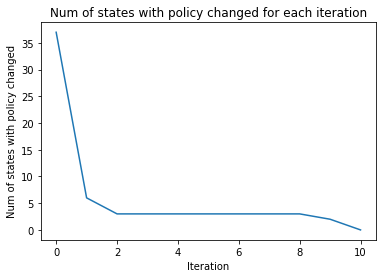

In [5]:
start_time = time.time()
policy, v, nums_of_states_with_policy_changed = policy_improvement(env)
end_time = time.time()
print('Policy iteration converged after {0} iterations in {1} seconds'
      .format(len(nums_of_states_with_policy_changed), end_time - start_time))

print("Policy Probability Distribution:")
print(policy)

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))

print("Value Function:")
print(v)

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))

plt.plot(nums_of_states_with_policy_changed)
plt.xlabel('Iteration')
plt.ylabel('Num of states with policy changed')
plt.title('Num of states with policy changed for each iteration')